In [ ]:
# JesseRuiz_nlp_project_Codeup_2019

In [1]:
from requests import get
import requests
from bs4 import BeautifulSoup
import os
import json
from pprint import pprint
import re

import itertools as it
from typing import List, Dict
import pandas as pd

import numpy as np
import unicodedata

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings("ignore")

import time
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

random_state=123
import random

In [2]:
# Found on https://madnight.github.io/githut/#/pull_requests/2019/1
langs = ['JavaScript',
'Python',
'Java',
'Go',
'C++',
'Ruby',
'PHP',
'TypeScript',
'C#',
'C',
'Shell',
'Scala',
'Swift',
'Rust',
'Kotlin',
'Objective-C',
'Groovy',
'Elixir',
'Lua',
'DM',
'Perl',
'Dart',
'Clojure',
'PowerShell',
'CoffeeScript',
'Haskell',
'OCaml',
'R',
'Emacs Lisp',
'Vim script',
'Jsonnet',
'Erlang',
'Puppet',
'Julia',
'Smalltalk',
'MATLAB',
'WebAssembly',
'Fortran',
'F#',
'Visual Basic',
'Apex',
'ABAP',
'Vala',
'Nix',
'Crystal',
'Roff',
'Perl 6',
'FreeMarker',
'PureScript',
'Objective-C++',
'HTML',
'CSS',
'Vue']

In [3]:
langs = [element.lower() for element in langs]
langs

['javascript',
 'python',
 'java',
 'go',
 'c++',
 'ruby',
 'php',
 'typescript',
 'c#',
 'c',
 'shell',
 'scala',
 'swift',
 'rust',
 'kotlin',
 'objective-c',
 'groovy',
 'elixir',
 'lua',
 'dm',
 'perl',
 'dart',
 'clojure',
 'powershell',
 'coffeescript',
 'haskell',
 'ocaml',
 'r',
 'emacs lisp',
 'vim script',
 'jsonnet',
 'erlang',
 'puppet',
 'julia',
 'smalltalk',
 'matlab',
 'webassembly',
 'fortran',
 'f#',
 'visual basic',
 'apex',
 'abap',
 'vala',
 'nix',
 'crystal',
 'roff',
 'perl 6',
 'freemarker',
 'purescript',
 'objective-c++',
 'html',
 'css',
 'vue']

In [ ]:
# Function shows a list of labels (Programming Language) of a repository. 
# The function takes a BeautifulSoup ResultSet and returns a list.
def get_labels(bs4resultset):
    labels = []
    for div in bs4resultset:
        repo_list = re.findall(r'.+', div.text.lower())
        lang = list(set(repo_list) & set(langs))
        if lang != []:
            labels.append(lang[0])
        else:
            labels.append('na')
    return labels


In [ ]:
# Function shows what the user/repo_name and the label (Programming Language) is... 
# Creates a list of lists.

def repo_name_and_label(bs4resultset):
    name_label = []
    for div in bs4resultset:
        one = []
        one.append(re.findall(r'.*\s/\s.*',div.text)[0])
        lang = list(set(re.findall(r'.+', div.text.lower())) & set(langs))
        if lang != []:
            one.append(lang[0])
        else:
            one.append('na')
        name_label.append(one)
    return name_label

## Acquire

### General approach to choosing what type of data to scrape from Github: 
#### Use the url: https://github.com/search?o=desc&q=stars%3A%3E1&s=updated&type=Repositories
### This page shows the most recently updates repos on Github.

In [ ]:
base_url = 'https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=updated&type=Repositories'

In [ ]:
headers = {'User-Agent': 'student'} # codeup.com doesn't like our default user-agent
response = get(base_url)

In [ ]:
print(response.text[:400])

In [ ]:
pprint(response.text)

### Create a BeautifulSoup object

In [ ]:
soup = BeautifulSoup(response.content, 'html.parser')


In [ ]:
soup

### This looks for the repo class, which is structured differently than the TRENDING page which we used before...
### Each page contains 10 repos... 

In [ ]:
# We search for all the repositories that have the following class. We should get back 25 objects.
repo2 = soup.findAll('li', class_='repo-list-item d-flex flex-column flex-md-row flex-justify-start py-4 public source')
print(type(repo2))

In [ ]:
print(len(repo2))

In [ ]:
# Show what the repo looks like

for div in repo2:
    print(div.text)

### Now that we have an entirely different HTML text structure, we have to write new regex to capture the relevant information.

### This function crawls across multiple pages to scrape these pages. Aiming for 150 repos, which is 15 pages.

In [ ]:
repo2

In [ ]:
for div in repo2:
    print(div.text)

In [ ]:
# Function shows what the user/repo_name and the label (Programming Language) is... 
# Creates a list of lists.

def repo_name_and_label(bs4resultset):
    name_label = []
    for div in bs4resultset:
        one = []
        one.append(re.findall(r'.*/.*',div.text)[0])
        lang = list(set(re.findall(r'.+', div.text.lower())) & set(langs))
        if lang != []:
            one.append(lang[0])
        else:
            one.append('na')
        name_label.append(one)
    return name_label

In [ ]:
repo_name_and_label(repo2)

In [ ]:
# Finds the user/repo_name...
for div in repo2:
#     print(div.text)
    print(re.findall(r'.*/.*',div.text)[0])

In [ ]:
# Finds the number of stars...
for div in repo2:
#     print(div.text)
    print(re.findall(r'(\d)', div.text))

### Okay, this can't be achieved with Regex that easily... going to webscrape from the Repo site instead...

### How to find the URLS from many pages on this page: 
https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=updated&type=Repositories

In [ ]:
def get_url_list():
    '''Finds a long list of urls based on a max number of pages, which is hardcoded into the function.'''
    urls = []
    headers = {'User-Agent': 'Student'}
    url = 'https://github.com/search?o=desc&p=1&q=stars%3A%3E1&s=updated&type=Repositories'
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    max_page = 100
    for i in range(1,max_page):
        url = 'https://github.com/search?o=desc&p=' + str(i) + '&q=stars%3A%3E1&s=updated&type=Repositories/'
        print(f'traversing url: {url}')
        response = get(url, headers=headers)
        soup = BeautifulSoup(response.text)
          
        repo = soup.findAll('li', class_='repo-list-item d-flex flex-column flex-md-row flex-justify-start py-4 public source')
        for div in repo:
            one = []
            one.append(re.findall(r'.*/.*',div.text)[0])
            urls.append(one)
        time.sleep(3)
        print(len(urls))        
#         print(urls)
    final_urls = []
    for url in urls:
        url = 'https://github.com/'+url[0]
        final_urls.append(url)
        
        
    return final_urls
            

In [ ]:
first_url_list = get_url_list()

In [ ]:
first_url_list

# Function name: get_url_list()
## This is the desired list of urls because we can use this function to find more than 100 repositories. The number of pages to scrape is hard coded into the function.

In [ ]:
first_url_list[0]

In [ ]:
def get_article_text(list):
    '''Takes a list of urls and pulls the README text into a dataframe and returns the dataframe.'''
    good_blobs = []
    read_me_list = []
    
    for element in list:
        url = element + '/blob/master/README.md'
        response = requests.get(url)
        soup = BeautifulSoup(response.text)
        read_me = soup.find(class_='markdown-body entry-content p-3 p-md-6')
#         read_me_list.append(str(blob) + ':')
        time.sleep(3)
        if read_me != None:
        
            read_me_list.append(read_me.text)
            good_blobs.append(element)
    result = pd.DataFrame(np.column_stack([good_blobs, read_me_list]), columns=['repo_name', 'readme'])
    return result

In [ ]:
def get_repo_all(urls):
    '''Takes a list of urls and returns a dataframe with the repo title, the repos programming language, the original text of the 
    README file and the number of stars that the repo has. If there were multiple languages, 
    we took the language that had the highest percentage.'''
    good_blobs = []
    read_me_list = []
    language_top = []
    stars = []
    for url in urls:
        response = requests.get(url)        
        soup = BeautifulSoup(response.text)
        read_me = soup.find(class_='markdown-body entry-content p-5')
        
        if read_me != None:
            if soup.find('span', class_='lang') != None:
                language_rm = soup.find('span', class_='lang').text
                language_top.append(language_rm)
            else: 
                language_top.append('None')
                
            if soup.find('a', class_='social-count js-social-count') != None:
                stars.append((re.findall(r'(\d+)', soup.find('a', class_='social-count js-social-count').attrs['aria-label']))[0])
            else:
                stars.append('None')
            read_me_list.append(read_me.text)
            good_blobs.append(url.split('/', 3)[-1])       
            time.sleep(3)
            print('Total number of repos scraped...', len(good_blobs))
    df = pd.DataFrame(list(zip(good_blobs,language_top, read_me_list, stars)))
    df.columns = ['title', 'language', 'original', 'stars']
    return df

In [ ]:
df = get_repo_all(first_url_list)

In [ ]:
df.to_csv('github_large_data3.csv', index=False)

In [ ]:
df.sample(30)

# Prepare

### We have a working master notebook that saves a large dataframe with all the repos. Because this is so big, we saved it to a csv. 

### Read in CSV.

## First run of modeling, we acquired about 150 repos to do modeling. -> github_data.csv

## Second run through, we acquired about 522 repos. -> github_large_data.csv

## Third run through, we acquired about 500 repos. -> github_large_data2.csv

## Fourth run through, we acquired about 500 repos. -> github_large_data3.csv

In [4]:
from env import path

### Leaving the work for the first modeling phase below...

In [5]:
file = 'github_large_data.csv'

In [6]:
df1 = pd.read_csv(path+file, header='infer', index_col=0)

In [7]:
df1

,language,original,stars
title,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5
u-simon/springCloudDemo,Java,springCloudDemo\n,2
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46
JingningShi/MtreeRing,R,"MtreeRing\nAuthors: Jingning Shi, Wei Xiang\nL...",2
yongzhuo/nlp_xiaojiang,Python,nlp_xiaojiang\nAugmentText\n- 回译（效果比较好）\n- EDA...,19
alexherbo2/site,JavaScript,Site\nConfiguration | Theme | Builds | Contrib...,2
opengeospatial/geotiff,HTML,geotiff\nThe key folder where the asciidoc spe...,6


In [8]:
df1.shape

(522, 3)

In [9]:
gh = df1.copy()

In [10]:
gh.shape

(522, 3)

In [11]:
file2 = 'github_large_data2.csv'

In [12]:
df2 = pd.read_csv(path+file2, header='infer', index_col=0)

In [13]:
df2.head()

,language,original,stars
title,,,
PineconePi/Pinecone_Pi_Nano,C,PineconePi Nano（Click to enter the website，Sup...,20
sgo230/Sisense,Python,Sisense\nCode Snippets for Sisense\n,4
Lombiq/Tidy-Orchard-Development-Toolkit,C#,Tidy Orchard Development Toolkit Readme\nThe T...,3
textlint-ja/textlint-rule-preset-japanese,JavaScript,textlint-rule-preset-japanese \ntextlint rule ...,26
chipsec/chipsec,C,CHIPSEC: Platform Security Assessment Framewor...,1790


In [14]:
file3 = 'github_large_data3.csv'

In [15]:
df3 = pd.read_csv(path+file3, header='infer', index_col=0)

In [16]:
df3.head()

,language,original,stars
title,,,
Imaginary11/api-gateway,Java,api-gateway\n基于SpringCloudGateway 实现的网关，包含动态路由...,7
charles9n/bert-sklearn,Jupyter Notebook,scikit-learn wrapper for BERT\nA scikit-learn ...,24
CodeDarigan/WAT,GDScript,WAT Alpha\n\nWhat is WAT?\nWAT (Waiting and Te...,11
Ogg-Technologies/warframe-database,None,warframe-database\nContains data about warframe\n,2
dddjava/Jig,Java,JIG\nJIGの紹介\nコンセプト\n三層＋ドメインモデルのアーキテクチャで実装されたコー...,55


### Combine the dataframes into one master

In [17]:
frames = [df1, df2 ,df3]

In [18]:
df = pd.concat(frames)

In [19]:
df.head()

,language,original,stars
title,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5
u-simon/springCloudDemo,Java,springCloudDemo\n,2
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46


In [20]:
df.shape

(1524, 3)

In [21]:
df.tail()

,language,original,stars
title,,,
nicohman/wyvern,Rust,wyvern \nWyvern is a command-line tool writte...,59
dotclear/dotclear,JavaScript,README\nWHAT IS DOTCLEAR ?\nDotclear is an ope...,11
mozilla-tw/FirefoxLite,Java,Firefox Lite\n\nGetting Involved\nWe encourage...,145
lutris/lutris,Python,Lutris\n\nLutris is an open source gaming plat...,2040
chef/chef-dk,Ruby,Chef Development Kit\n\n\n\n\n\nUmbrella Proje...,386


In [22]:
df.head()

,language,original,stars
title,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5
u-simon/springCloudDemo,Java,springCloudDemo\n,2
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46


## Clean

In [23]:
def original_word_count():
    df[['original_cnt']] = df[['original']]
    art_nums = list(range(df.original.count()))
    for art_num in art_nums:
        df.original_cnt[art_num] = len(df['original'][art_num].split())
    df['original_cnt']=df['original_cnt'].astype(int)
    return df

In [24]:
original_word_count()
df.head()

,language,original,stars,original_cnt
title,,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5,111
u-simon/springCloudDemo,Java,springCloudDemo\n,2,1
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615


In [25]:
def basic_clean():
    
    df[['article']] = df[['original']]
    art_nums = list(range(df.original.count()))
    for art_num in art_nums:
        original = df.article[art_num]
        article = re.sub(r'\s', ' ', original).lower()
        normalized = unicodedata.normalize('NFKD', article)
        just_ascii = normalized.encode('ascii', 'ignore')
        article = just_ascii.decode('utf-8')
        without_special_chars = re.sub(r'[^\w\s]', ' ', article)
        word_list = without_special_chars.split()
        article_final = ' '.join(word_list)
        df.article[art_num] = article_final
    return df

In [26]:
basic_clean()

,language,original,stars,original_cnt,article
title,,,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...
u-simon/springCloudDemo,Java,springCloudDemo\n,2,1,springclouddemo
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...
JingningShi/MtreeRing,R,"MtreeRing\nAuthors: Jingning Shi, Wei Xiang\nL...",2,466,mtreering authors jingning shi wei xiang licen...
yongzhuo/nlp_xiaojiang,Python,nlp_xiaojiang\nAugmentText\n- 回译（效果比较好）\n- EDA...,19,184,nlp_xiaojiang augmenttext eda hmm marko syntax...
alexherbo2/site,JavaScript,Site\nConfiguration | Theme | Builds | Contrib...,2,14,site configuration theme builds contributing p...
opengeospatial/geotiff,HTML,geotiff\nThe key folder where the asciidoc spe...,6,35,geotiff the key folder where the asciidoc spec...


In [27]:
def article_word_count():
    df[['article_cnt']] = df[['article']]
    art_nums = list(range(df.original.count()))
    for art_num in art_nums:
        df.article_cnt[art_num] = len(df['article'][art_num].split())
    df['article_cnt']=df['article_cnt'].astype(int)
    return df

In [28]:
article_word_count()

,language,original,stars,original_cnt,article,article_cnt
title,,,,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124
u-simon/springCloudDemo,Java,springCloudDemo\n,2,1,springclouddemo,1
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797
JingningShi/MtreeRing,R,"MtreeRing\nAuthors: Jingning Shi, Wei Xiang\nL...",2,466,mtreering authors jingning shi wei xiang licen...,482
yongzhuo/nlp_xiaojiang,Python,nlp_xiaojiang\nAugmentText\n- 回译（效果比较好）\n- EDA...,19,184,nlp_xiaojiang augmenttext eda hmm marko syntax...,293
alexherbo2/site,JavaScript,Site\nConfiguration | Theme | Builds | Contrib...,2,14,site configuration theme builds contributing p...,11
opengeospatial/geotiff,HTML,geotiff\nThe key folder where the asciidoc spe...,6,35,geotiff the key folder where the asciidoc spec...,45


In [29]:
def article_percent():
    '''This function calculates what percentage of the original text was kept after the basic clean function.'''
    df[['article_per_kept']] = df[['article_cnt']]
    df[['article_per_kept']] = df.article_cnt / df.original_cnt
    df['article_per_kept']=df['article_per_kept'].astype(float)
    return df

In [30]:
article_percent()


,language,original,stars,original_cnt,article,article_cnt,article_per_kept
title,,,,,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124,1.117117
u-simon/springCloudDemo,Java,springCloudDemo\n,2,1,springclouddemo,1,1.000000
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568,1.021583
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693
JingningShi/MtreeRing,R,"MtreeRing\nAuthors: Jingning Shi, Wei Xiang\nL...",2,466,mtreering authors jingning shi wei xiang licen...,482,1.034335
yongzhuo/nlp_xiaojiang,Python,nlp_xiaojiang\nAugmentText\n- 回译（效果比较好）\n- EDA...,19,184,nlp_xiaojiang augmenttext eda hmm marko syntax...,293,1.592391
alexherbo2/site,JavaScript,Site\nConfiguration | Theme | Builds | Contrib...,2,14,site configuration theme builds contributing p...,11,0.785714
opengeospatial/geotiff,HTML,geotiff\nThe key folder where the asciidoc spe...,6,35,geotiff the key folder where the asciidoc spec...,45,1.285714


In [31]:
def lemmatize():
    
    df[['lemmatized']] = df[['article']]
    art_nums = list(range(df.article.count()))
    wnl = nltk.stem.WordNetLemmatizer()
    for art_num in art_nums:
        lemm_article = df.lemmatized[art_num]
        lemmas = [wnl.lemmatize(word) for word in lemm_article.split()]
        article_lemmatized = ' '.join(lemmas)
        df.lemmatized[art_num] = article_lemmatized
    return df

In [32]:
lemmatize()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized
title,,,,,,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124,1.117117,magento2 similar product magento 2 similarity ...
u-simon/springCloudDemo,Java,springCloudDemo\n,2,1,springclouddemo,1,1.000000,springclouddemo
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568,1.021583,license amrex copyright c 2017 the regent of t...
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...
JingningShi/MtreeRing,R,"MtreeRing\nAuthors: Jingning Shi, Wei Xiang\nL...",2,466,mtreering authors jingning shi wei xiang licen...,482,1.034335,mtreering author jingning shi wei xiang licens...
yongzhuo/nlp_xiaojiang,Python,nlp_xiaojiang\nAugmentText\n- 回译（效果比较好）\n- EDA...,19,184,nlp_xiaojiang augmenttext eda hmm marko syntax...,293,1.592391,nlp_xiaojiang augmenttext eda hmm marko syntax...
alexherbo2/site,JavaScript,Site\nConfiguration | Theme | Builds | Contrib...,2,14,site configuration theme builds contributing p...,11,0.785714,site configuration theme build contributing pe...
opengeospatial/geotiff,HTML,geotiff\nThe key folder where the asciidoc spe...,6,35,geotiff the key folder where the asciidoc spec...,45,1.285714,geotiff the key folder where the asciidoc spec...


In [33]:
def lemm_word_count():
    df[['lemm_cnt']] = df[['article']]
    art_nums = list(range(df.original.count()))
    for art_num in art_nums:
        df.lemm_cnt[art_num] = len(df['lemmatized'][art_num].split())
        
    df.lemm_cnt = df.lemm_cnt.astype(int)
    return df

In [34]:
lemm_word_count()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt
title,,,,,,,,,
NetBSD/src,None,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188
morozov-group/magento2-similar-products,PHP,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124,1.117117,magento2 similar product magento 2 similarity ...,124
u-simon/springCloudDemo,Java,springCloudDemo\n,2,1,springclouddemo,1,1.000000,springclouddemo,1
AMReX-Codes/amrex,C++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568,1.021583,license amrex copyright c 2017 the regent of t...,568
joeynmt/joeynmt,Python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...,1797
JingningShi/MtreeRing,R,"MtreeRing\nAuthors: Jingning Shi, Wei Xiang\nL...",2,466,mtreering authors jingning shi wei xiang licen...,482,1.034335,mtreering author jingning shi wei xiang licens...,482
yongzhuo/nlp_xiaojiang,Python,nlp_xiaojiang\nAugmentText\n- 回译（效果比较好）\n- EDA...,19,184,nlp_xiaojiang augmenttext eda hmm marko syntax...,293,1.592391,nlp_xiaojiang augmenttext eda hmm marko syntax...,293
alexherbo2/site,JavaScript,Site\nConfiguration | Theme | Builds | Contrib...,2,14,site configuration theme builds contributing p...,11,0.785714,site configuration theme build contributing pe...,11
opengeospatial/geotiff,HTML,geotiff\nThe key folder where the asciidoc spe...,6,35,geotiff the key folder where the asciidoc spec...,45,1.285714,geotiff the key folder where the asciidoc spec...,45


### Examine how the lemmatize function worked... It looks like it didn't do TOO much work.

In [35]:
df['article'].iloc[0]


'netbsd netbsd is a free fast secure and highly portable unix like open source operating system it is available for a wide range of platforms from large scale servers and powerful desktop systems to handheld and embedded devices building you can cross build netbsd from most unix like operating systems to build for amd64 x86_64 in the src directory build sh u u j4 m amd64 o obj release additional build information available in the building file binaries daily builds releases testing on a running netbsd system cd usr tests atf run atf report troubleshooting send bugs and patches via web form subscribe to the mailing lists the netbsd users list is a good choice for many problems watch current users if you follow the bleeding edge of netbsd current join the community irc channel netbsd freenode latest sources to fetch the main cvs repository cvs d anoncvs anoncvs netbsd org cvsroot checkout p src to work in the git mirror which is updated every few hours from cvs git clone https github com

In [36]:
df['lemmatized'].iloc[0]

# df.loc[df['A'] == 'foo']

'netbsd netbsd is a free fast secure and highly portable unix like open source operating system it is available for a wide range of platform from large scale server and powerful desktop system to handheld and embedded device building you can cross build netbsd from most unix like operating system to build for amd64 x86_64 in the src directory build sh u u j4 m amd64 o obj release additional build information available in the building file binary daily build release testing on a running netbsd system cd usr test atf run atf report troubleshooting send bug and patch via web form subscribe to the mailing list the netbsd user list is a good choice for many problem watch current user if you follow the bleeding edge of netbsd current join the community irc channel netbsd freenode latest source to fetch the main cv repository cv d anoncvs anoncvs netbsd org cvsroot checkout p src to work in the git mirror which is updated every few hour from cv git clone http github com netbsd src git additio

## Explore the data that you have scraped. Here are some ideas for exploration:

* What are the most common words in READMEs?
* What does the distribution of IDFs look like for the most common words?
* Does the length of the README vary by language?
* Do different languages use a different number of unique words?

In [37]:
df.dtypes

language             object
original             object
stars                 int64
original_cnt          int64
article              object
article_cnt           int64
article_per_kept    float64
lemmatized           object
lemm_cnt              int64
dtype: object

In [38]:
df.language.value_counts()

JavaScript             211
Python                 189
C++                    125
None                   113
Java                    96
C#                      92
C                       77
HTML                    65
TypeScript              58
Go                      56
Shell                   54
PHP                     44
Rust                    34
Jupyter Notebook        30
Ruby                    30
CSS                     29
R                       17
Swift                   16
Haskell                 15
PowerShell              13
Vue                     10
Lua                     10
Kotlin                  10
Vim script               9
Dart                     8
Perl                     8
Scala                    8
Objective-C              7
Clojure                  5
Groovy                   5
                      ... 
Lean                     2
TeX                      2
Dockerfile               2
Erlang                   2
IDL                      2
Haxe                     2
O

### Make sure the language column is lower cased

In [39]:
df['language'] = df['language'].str.lower()

In [40]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt
title,,,,,,,,,
NetBSD/src,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188
morozov-group/magento2-similar-products,php,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124,1.117117,magento2 similar product magento 2 similarity ...,124
u-simon/springCloudDemo,java,springCloudDemo\n,2,1,springclouddemo,1,1.000000,springclouddemo,1
AMReX-Codes/amrex,c++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568,1.021583,license amrex copyright c 2017 the regent of t...,568
joeynmt/joeynmt,python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...,1797


In [41]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt
title,,,,,,,,,
NetBSD/src,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188
morozov-group/magento2-similar-products,php,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124,1.117117,magento2 similar product magento 2 similarity ...,124
u-simon/springCloudDemo,java,springCloudDemo\n,2,1,springclouddemo,1,1.000000,springclouddemo,1
AMReX-Codes/amrex,c++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568,1.021583,license amrex copyright c 2017 the regent of t...,568
joeynmt/joeynmt,python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...,1797


In [42]:
def remove_stopwords(string, string_or_list='string', extra_words=None, exclude_words=None):
    """Removes the stopwords from the text then returns it. Able to add or remove stopwords."""
    stopword_list = stopwords.words('english') + langs
    if extra_words != None:
        for word in extra_words:
            stopword_list.append(word)
    if exclude_words != None:
        for word in exclude_words:
            stopword_list.remove(word)
    filtered_words = [word for word in string.split() if word not in stopword_list]
    filtered_string = ' '.join(filtered_words)
    if string_or_list == 'string':
        return filtered_string
    if string_or_list == 'list':
        return filtered_words

In [43]:
df['clean'] = df.article.apply(remove_stopwords)

In [44]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean
title,,,,,,,,,,
NetBSD/src,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...
morozov-group/magento2-similar-products,php,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124,1.117117,magento2 similar product magento 2 similarity ...,124,magento2 similar products magento 2 similarity...
u-simon/springCloudDemo,java,springCloudDemo\n,2,1,springclouddemo,1,1.000000,springclouddemo,1,springclouddemo
AMReX-Codes/amrex,c++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568,1.021583,license amrex copyright c 2017 the regent of t...,568,license amrex copyright 2017 regents universit...
joeynmt/joeynmt,python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...,1797,joey nmt goal purpose joey nmt framework devel...


### Drop repos that have a low wordcount in the Readme file

In [45]:
df = df[df.original_cnt > 10]

In [46]:
df.shape

(1385, 10)

In [47]:
df['word_cnt_after_stop'] = df.clean.str.split().str.len()
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop
title,,,,,,,,,,,
NetBSD/src,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139
morozov-group/magento2-similar-products,php,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124,1.117117,magento2 similar product magento 2 similarity ...,124,magento2 similar products magento 2 similarity...,89
AMReX-Codes/amrex,c++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568,1.021583,license amrex copyright c 2017 the regent of t...,568,license amrex copyright 2017 regents universit...,344
joeynmt/joeynmt,python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...,1797,joey nmt goal purpose joey nmt framework devel...,1234
JingningShi/MtreeRing,r,"MtreeRing\nAuthors: Jingning Shi, Wei Xiang\nL...",2,466,mtreering authors jingning shi wei xiang licen...,482,1.034335,mtreering author jingning shi wei xiang licens...,482,mtreering authors jingning shi wei xiang licen...,335


In [48]:
df['per_stopwords_kept'] = df.word_cnt_after_stop/df.lemm_cnt
df['per_overall_kept'] = df.word_cnt_after_stop/df.original_cnt

In [49]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
title,,,,,,,,,,,,,
NetBSD/src,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485
morozov-group/magento2-similar-products,php,magento2-similar-products\n\nMagento 2 Similar...,5,111,magento2 similar products magento 2 similarity...,124,1.117117,magento2 similar product magento 2 similarity ...,124,magento2 similar products magento 2 similarity...,89,0.717742,0.801802
AMReX-Codes/amrex,c++,"\nLicense\nAMReX Copyright (c) 2017, The Regen...",130,556,license amrex copyright c 2017 the regents of ...,568,1.021583,license amrex copyright c 2017 the regent of t...,568,license amrex copyright 2017 regents universit...,344,0.605634,0.618705
joeynmt/joeynmt,python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...,1797,joey nmt goal purpose joey nmt framework devel...,1234,0.686700,0.764087
JingningShi/MtreeRing,r,"MtreeRing\nAuthors: Jingning Shi, Wei Xiang\nL...",2,466,mtreering authors jingning shi wei xiang licen...,482,1.034335,mtreering author jingning shi wei xiang licens...,482,mtreering authors jingning shi wei xiang licen...,335,0.695021,0.718884


## In the first modeling phase, we focused on the top 5 most frequently used languages.
## In the second modeling phase, we focused on the top 11 programming languages. But we found this was too many to make good predictions on so we changed this back to top 5 languages.

## In this third modeling phase, we have a lot more data. We will focus on the top 9 languages.

In [50]:
top_langs2 = pd.DataFrame(df['language'].value_counts()[df['language'].value_counts()>50])
top_langs2.reset_index(inplace=True)
top_langs2.columns = ['language', 'count']
top_langs2

,language,count
0,javascript,202
1,python,173
2,c++,115
3,c#,86
4,none,85
5,java,82
6,c,74
7,typescript,56
8,go,55


In [51]:
top_langs_list = list(top_langs2.language)
top_langs_list

['javascript', 'python', 'c++', 'c#', 'none', 'java', 'c', 'typescript', 'go']

## Now that we know which labels we are targeting (Top 9 languages), we can stick these into the dataframe to filter down the df to just these observations. We do this with a merge function.

In [52]:
df = pd.merge(df, top_langs2, on='language', how='inner')
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,count
0,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485,85
1,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485,85
2,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397,85
3,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429,85
4,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377,85


In [53]:
df = df.drop(df.index[0])

In [54]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,count
1,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485,85
2,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397,85
3,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429,85
4,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377,85
5,none,hak.lnk\nProject Name: hak.lnk\nDescription: R...,18,64,hak lnk project name hak lnk description resou...,59,0.921875,hak lnk project name hak lnk description resou...,59,hak lnk project name hak lnk description resou...,48,0.813559,0.750000,85


In [55]:
df.reset_index(inplace=True)

In [56]:
df.head()

,index,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,count
0,1,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485,85
1,2,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397,85
2,3,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429,85
3,4,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377,85
4,5,none,hak.lnk\nProject Name: hak.lnk\nDescription: R...,18,64,hak lnk project name hak lnk description resou...,59,0.921875,hak lnk project name hak lnk description resou...,59,hak lnk project name hak lnk description resou...,48,0.813559,0.750000,85


In [57]:
df.drop(['count', 'index'], axis=1, inplace=True)
df.head(3)

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
0,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485
1,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397
2,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429


In [58]:
df.shape

(927, 13)

### Now we have a dataframewhich has 927 entries. These are the repos that have 9 most occuring languages.

## Visualize

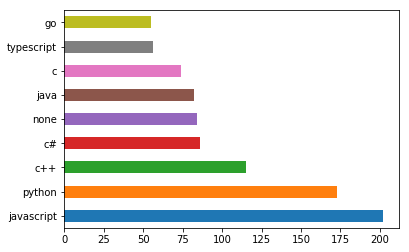

In [59]:
df.language.value_counts().plot.barh()

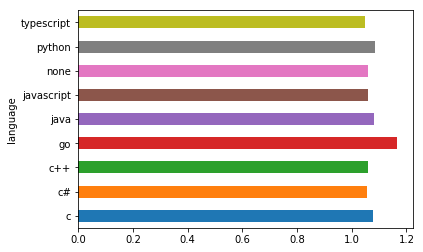

In [60]:
df.groupby('language')['article_per_kept'].mean().plot.barh()

### Explore the repos readme's that are PYTHON language...

In [61]:
py = df[df.language == 'python']
py.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
199,python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...,1797,joey nmt goal purpose joey nmt framework devel...,1234,0.686700,0.764087
200,python,nlp_xiaojiang\nAugmentText\n- 回译（效果比较好）\n- EDA...,19,184,nlp_xiaojiang augmenttext eda hmm marko syntax...,293,1.592391,nlp_xiaojiang augmenttext eda hmm marko syntax...,293,nlp_xiaojiang augmenttext eda hmm marko syntax...,275,0.938567,1.494565
201,python,JustWatchAPI\n\nJustWatch.com Python 3 API\nIn...,70,368,justwatchapi justwatch com python 3 api instal...,409,1.111413,justwatchapi justwatch com python 3 api instal...,409,justwatchapi justwatch com 3 api install pytho...,292,0.713936,0.793478
202,python,Swift Source Compatibility Suite\nSource compa...,197,1130,swift source compatibility suite source compat...,1218,1.077876,swift source compatibility suite source compat...,1218,source compatibility suite source compatibilit...,853,0.700328,0.754867
203,python,Joey NMT\n\nGoal and Purpose\nJoey NMT fram...,46,1615,joey nmt goal and purpose joey nmt framework i...,1797,1.112693,joey nmt goal and purpose joey nmt framework i...,1797,joey nmt goal purpose joey nmt framework devel...,1234,0.686700,0.764087


In [62]:
py_words = ' '.join(py.clean)

(-0.5, 399.5, 199.5, -0.5)

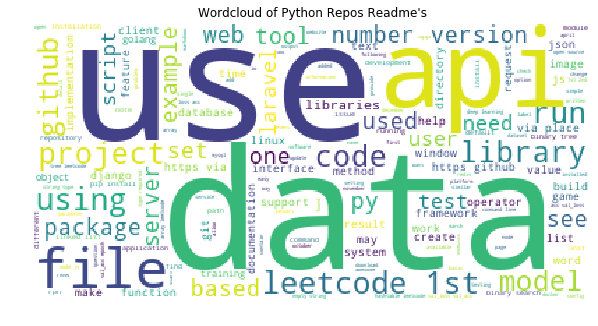

In [63]:
from wordcloud import WordCloud
img = WordCloud(background_color='white').generate(py_words)
# WordCloud() produces an image object, which can be displayed with plt.imshow
plt.figure(figsize=(10,10))
plt.imshow(img)

plt.title('Wordcloud of Python Repos Readme\'s')
plt.axis('off')

### This shows us artifact, test and use are used a lot in Python Repo Readme files.

In [64]:
all_words = ' '.join(df.clean)
all_freq = pd.Series(all_words).value_counts()


### Compare the Python words with the All words collection in a Wordcloud

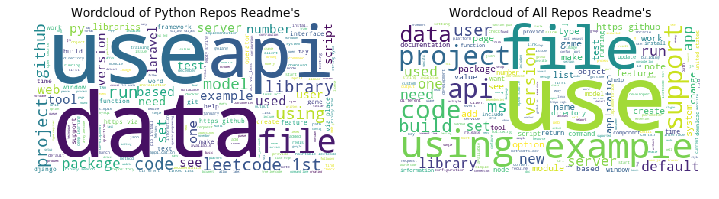

In [65]:
plt.figure(figsize=(12,8))

plt.subplot(1, 2, 1)
img = WordCloud(background_color='white').generate(py_words)
plt.imshow(img)
plt.title('Wordcloud of Python Repos Readme\'s')
plt.axis('off')

plt.subplot(1, 2, 2)
img = WordCloud(background_color='white').generate(all_words)
plt.imshow(img)
plt.title('Wordcloud of All Repos Readme\'s')
plt.axis('off')

# fig.tight_layout(pad=2)

plt.box(False)

In [66]:
mean_df = df.groupby('language').mean()
mean_df

,stars,original_cnt,article_cnt,article_per_kept,lemm_cnt,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
language,,,,,,,,
c,1924.040541,464.594595,490.027027,1.078368,490.027027,327.391892,0.703846,0.764327
c#,608.872093,491.755814,523.976744,1.056270,523.976744,358.244186,0.693574,0.724616
c++,4426.356522,719.034783,768.756522,1.058669,768.756522,514.686957,0.708846,0.751567
go,2122.581818,542.036364,640.218182,1.165663,640.218182,461.818182,0.718109,0.856250
java,1037.060976,437.402439,487.670732,1.082051,487.670732,344.158537,0.739969,0.803507
javascript,2267.821782,558.722772,586.589109,1.059785,586.589109,408.074257,0.721430,0.764063
none,418.726190,443.238095,526.535714,1.060329,526.535714,429.869048,0.796540,0.838808
python,1620.115607,720.612717,760.537572,1.086390,760.537572,548.653179,0.693915,0.758393
typescript,2580.803571,521.732143,546.410714,1.049634,546.410714,395.678571,0.736782,0.772787


In [67]:

mean_df[['Words Gained During Basic Clean']] = mean_df[['original_cnt']]
mean_df[['Words Lost After Stop Words']] = mean_df[['original_cnt']]
mean_df[['Words Gained During Basic Clean']] = pd.DataFrame(mean_df.article_cnt - mean_df.original_cnt)
mean_df[['Words Lost After Stop Words']] = pd.DataFrame(mean_df['article_cnt'] - mean_df['word_cnt_after_stop'])
mean_df

,stars,original_cnt,article_cnt,article_per_kept,lemm_cnt,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,Words Gained During Basic Clean,Words Lost After Stop Words
language,,,,,,,,,,
c,1924.040541,464.594595,490.027027,1.078368,490.027027,327.391892,0.703846,0.764327,25.432432,162.635135
c#,608.872093,491.755814,523.976744,1.056270,523.976744,358.244186,0.693574,0.724616,32.220930,165.732558
c++,4426.356522,719.034783,768.756522,1.058669,768.756522,514.686957,0.708846,0.751567,49.721739,254.069565
go,2122.581818,542.036364,640.218182,1.165663,640.218182,461.818182,0.718109,0.856250,98.181818,178.400000
java,1037.060976,437.402439,487.670732,1.082051,487.670732,344.158537,0.739969,0.803507,50.268293,143.512195
javascript,2267.821782,558.722772,586.589109,1.059785,586.589109,408.074257,0.721430,0.764063,27.866337,178.514851
none,418.726190,443.238095,526.535714,1.060329,526.535714,429.869048,0.796540,0.838808,83.297619,96.666667
python,1620.115607,720.612717,760.537572,1.086390,760.537572,548.653179,0.693915,0.758393,39.924855,211.884393
typescript,2580.803571,521.732143,546.410714,1.049634,546.410714,395.678571,0.736782,0.772787,24.678571,150.732143


In [68]:
mean_df = mean_df.reset_index()
mean_df

,language,stars,original_cnt,article_cnt,article_per_kept,lemm_cnt,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,Words Gained During Basic Clean,Words Lost After Stop Words
0,c,1924.040541,464.594595,490.027027,1.078368,490.027027,327.391892,0.703846,0.764327,25.432432,162.635135
1,c#,608.872093,491.755814,523.976744,1.056270,523.976744,358.244186,0.693574,0.724616,32.220930,165.732558
2,c++,4426.356522,719.034783,768.756522,1.058669,768.756522,514.686957,0.708846,0.751567,49.721739,254.069565
3,go,2122.581818,542.036364,640.218182,1.165663,640.218182,461.818182,0.718109,0.856250,98.181818,178.400000
4,java,1037.060976,437.402439,487.670732,1.082051,487.670732,344.158537,0.739969,0.803507,50.268293,143.512195
5,javascript,2267.821782,558.722772,586.589109,1.059785,586.589109,408.074257,0.721430,0.764063,27.866337,178.514851
6,none,418.726190,443.238095,526.535714,1.060329,526.535714,429.869048,0.796540,0.838808,83.297619,96.666667
7,python,1620.115607,720.612717,760.537572,1.086390,760.537572,548.653179,0.693915,0.758393,39.924855,211.884393
8,typescript,2580.803571,521.732143,546.410714,1.049634,546.410714,395.678571,0.736782,0.772787,24.678571,150.732143


In [69]:
mean_df.rename(columns = {'word_cnt_after_stop': 'Final Word Count'}, inplace=True)


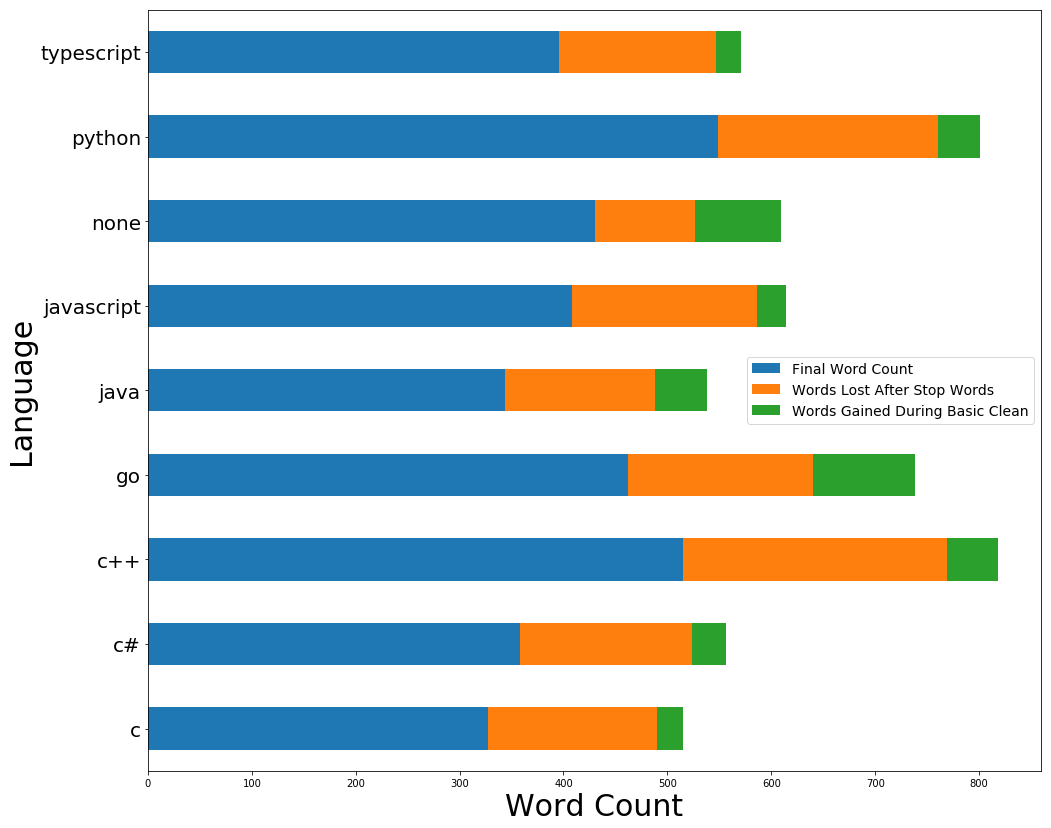

In [70]:
mean_df[['Final Word Count', 'Words Lost After Stop Words', 'Words Gained During Basic Clean']].plot.barh(stacked=True, figsize=(16, 14))
plt.ylabel('Language', fontsize=30, rotation=90)
plt.xlabel('Word Count', fontsize=30)
ticks, labels = plt.yticks()
labels = mean_df.language
plt.yticks(ticks, labels, fontsize=20)
plt.legend(fontsize=14, loc=7)
plt.show()

# Exploration

In [71]:
def df_info():
    cols = ['stars',
 'original_cnt',
 'article_cnt',
 'article_per_kept',
 'lemm_cnt',
 'word_cnt_after_stop',
 'per_stopwords_kept',
 'per_overall_kept']
    
    for col in cols:
        print(str(col) + ':')
        print(pd.DataFrame(df.groupby('language')[col].describe().T))

In [72]:
df_info()


stars:
language             c            c#            c++            go  \
count        74.000000     86.000000     115.000000     55.000000   
mean       1924.040541    608.872093    4426.356522   2122.581818   
std        4848.259147   2553.647757   14215.380310   7697.200113   
min           2.000000      2.000000       2.000000      2.000000   
25%           8.000000      4.000000      14.000000      4.500000   
50%          21.000000      6.500000     156.000000     24.000000   
75%        1637.250000     85.000000    2251.500000    893.500000   
max       23234.000000  16561.000000  127703.000000  52691.000000   

language          java     javascript        none        python    typescript  
count        82.000000     202.000000    84.00000    173.000000     56.000000  
mean       1037.060976    2267.821782   418.72619   1620.115607   2580.803571  
std        4859.765389   12770.382766  1385.79929   7998.957021   9195.158925  
min           2.000000       2.000000     2.00000  

language          c         c#         c++         go       java  javascript  \
count     74.000000  86.000000  115.000000  55.000000  82.000000  202.000000   
mean       0.764327   0.724616    0.751567   0.856250   0.803507    0.764063   
std        0.179038   0.149469    0.165121   0.435395   0.265139    0.205744   
min        0.523810   0.017857    0.111111   0.482993   0.500000    0.241379   
25%        0.616099   0.648400    0.637448   0.680896   0.637663    0.655492   
50%        0.738373   0.711111    0.721329   0.763158   0.733027    0.734205   
75%        0.847858   0.775276    0.827873   0.893375   0.882739    0.829969   
max        1.232143   1.368421    1.384615   3.713405   1.959184    2.287879   

language       none      python  typescript  
count     84.000000  173.000000   56.000000  
mean       0.838808    0.758393    0.772787  
std        0.317145    0.189835    0.170433  
min        0.130841    0.337088    0.533530  
25%        0.652520    0.644351    0.648052  
50%

In [73]:
def groupby_language_mean_plots():
    cols = ['stars',
 'original_cnt',
 'article_cnt',
 'article_per_kept',
 'lemm_cnt',
 'word_cnt_after_stop',
 'per_stopwords_kept',
 'per_overall_kept']
    
    for col in cols:
        print(str(col) + ':')
        plot = df.groupby('language')[col].mean().plot.barh()
        plt.show()

stars:


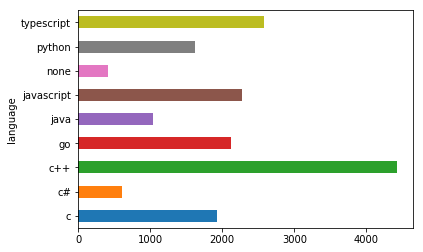

original_cnt:


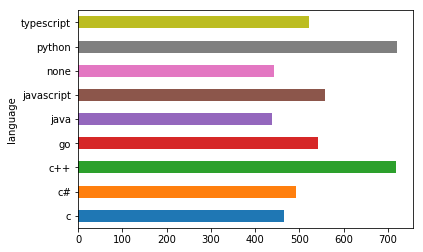

article_cnt:


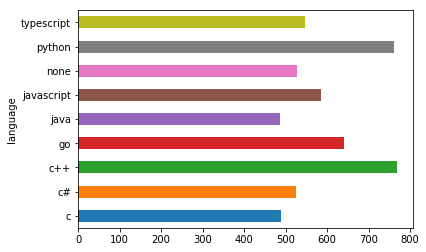

article_per_kept:


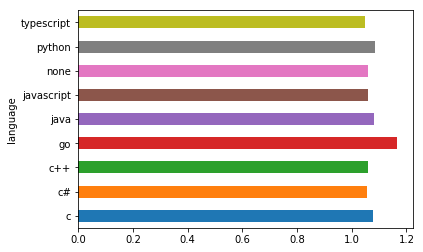

lemm_cnt:


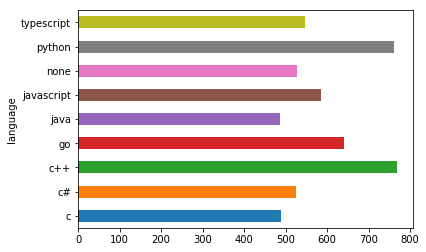

word_cnt_after_stop:


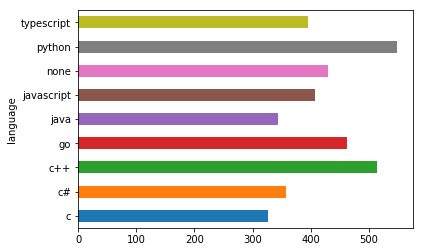

per_stopwords_kept:


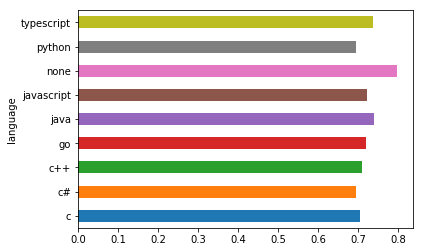

per_overall_kept:


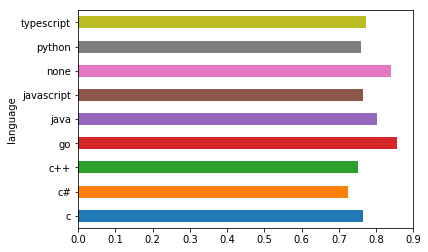

In [74]:
groupby_language_mean_plots()


# Models!

## Logistic Regression

In [75]:
df.language.value_counts(normalize=True)

javascript    0.217907
python        0.186624
c++           0.124056
c#            0.092772
none          0.090615
java          0.088457
c             0.079827
typescript    0.060410
go            0.059331
Name: language, dtype: float64

In [76]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
0,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485
1,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397
2,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429
3,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377
4,none,hak.lnk\nProject Name: hak.lnk\nDescription: R...,18,64,hak lnk project name hak lnk description resou...,59,0.921875,hak lnk project name hak lnk description resou...,59,hak lnk project name hak lnk description resou...,48,0.813559,0.750000


In [77]:
# df.clean.values

In [78]:
# df.language.values

In [79]:
docs = dict(zip(df.language.values, df.clean.values))

In [80]:
# docs

In [81]:
# docs.values()

In [82]:
df.shape

(927, 13)

In [83]:
tfidf = TfidfVectorizer()
tfidfs = tfidf.fit_transform(docs.values())
tfidfs

<9x1336 sparse matrix of type '<class 'numpy.float64'>'
	with 1789 stored elements in Compressed Sparse Row format>

In [84]:
sm = pd.DataFrame(tfidfs.todense(), columns=tfidf.get_feature_names())
sm

,02110,10,100,1000,1024,10k,12,127,128,1301,...,yaml,yarn,year,years,yet,yml,zendvm,zerda,zog,zsh
0,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
1,0.00000,0.000000,0.118450,0.024749,0.00825,0.074246,0.016499,0.090580,0.041248,0.00000,...,0.000000,0.000000,0.000000,0.006968,0.000000,0.000000,0.00825,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.018047,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.021367,0.000000,0.000000,0.000000,0.021367,0.085468,0.00000,0.000000,0.000000,0.000000
3,0.03916,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.03916,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.007467,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.061884,0.017681
5,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.035258,0.000000,0.000000
6,0.00000,0.024902,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.024902,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
7,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.088345,0.074618,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
8,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000


In [85]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

X = tfidf.fit_transform(df.clean)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2, random_state=random_state)
# not sure if we need to stratify y... so not doing it here... I think this is unneccessary because we dont have unbalanced set.
train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

lm = LogisticRegression().fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

In [86]:
X_train

<741x31778 sparse matrix of type '<class 'numpy.float64'>'
	with 134544 stored elements in Compressed Sparse Row format>

In [87]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 86.10%
---
Confusion Matrix
actual       c  c#  c++  go  java  javascript  none  python  typescript
predicted                                                              
c           40   0    0   0     0           0     0       0           0
c#           0  61    0   0     0           1     1       0           0
c++          0   0   92   0     0           0     0       0           0
go           0   0    0  26     0           0     0       0           0
java         0   0    0   0    60           0     1       0           0
javascript  13   7    0  14     4         159    10       1          34
none         0   0    0   0     0           0    53       0           0
python       6   1    0   4     2           1     2     137           1
typescript   0   0    0   0     0           0     0       0          10
---
              precision    recall  f1-score   support

           c       1.00      0.68      0.81        59
          c#       0.97      0.88      0.92        69
   

In [88]:
print('Accuracy: {:.2%}'.format(accuracy_score(test.actual, test.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(test.predicted, test.actual))
print('---')
print(classification_report(test.actual, test.predicted))

Accuracy: 55.91%
---
Confusion Matrix
actual      c  c#  c++  go  java  javascript  none  python  typescript
predicted                                                             
c           6   0    0   0     0           0     0       0           0
c#          0  11    0   0     0           1     0       0           0
c++         0   0   13   0     1           0     0       0           0
java        0   0    0   0     5           0     0       0           0
javascript  6   4    4   7     9          37     6       8          11
none        0   0    0   0     0           0     5       0           0
python      3   2    6   4     1           3     6      27           0
---
              precision    recall  f1-score   support

           c       1.00      0.40      0.57        15
          c#       0.92      0.65      0.76        17
         c++       0.93      0.57      0.70        23
          go       0.00      0.00      0.00        11
        java       1.00      0.31      0.48     

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Get some new random data

In [89]:
# this function will give a list of urls from a RANDOM page on GitHub.
def get_random_urls_list():
    '''Generates a list of 10 urls from a random page on GitHubs Most Recently Updated repos'''
    pg = random.choice(range(101))
    urls = []
    headers = {'User-Agent': 'Student'}
    url = 'https://github.com/search?o=desc&p='+ str(pg) + '&q=stars%3A%3E1&s=updated&type=Repositories'
    response = get(url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    repo = soup.findAll('li', class_='repo-list-item d-flex flex-column flex-md-row flex-justify-start py-4 public source')
    for div in repo:
        one = []
        one.append(re.findall(r'.*/.*',div.text)[0])
        urls.append(one)
#     print(len(urls))        
#         print(urls)
    final_urls = []
    for url in urls:
        url = 'https://github.com/'+url[0]
        final_urls.append(url)
    return final_urls

In [90]:
get_random_urls_list()

['https://github.com/SKocur/Image-Cipher',
 'https://github.com/ErickJMenezes/scc',
 'https://github.com/WarrenWeckesser/vfgen',
 'https://github.com/aburch/simutrans',
 'https://github.com/fuzetsu/mergerino',
 'https://github.com/pubkey/dhbw-thesis-roter-grubert',
 'https://github.com/reisub0/dot',
 'https://github.com/kindlyops/lambda-clamav-layer',
 'https://github.com/funilrys/PKGBUILD',
 'https://github.com/CODINGWIZZ/snowbot']

In [91]:
def clean(text):
    '''A simple function to cleanup text data'''
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english')
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    return [wnl.lemmatize(word) for word in words if word not in stopwords]


In [92]:
# Depends upon get_random_urls_list() function
def rand_url():
    '''Finds a random item from a list of urls. That list of urls is generated by another function, get_random_url_list()'''
    return random.choice(get_random_urls_list())

In [93]:
random_url = rand_url()
random_url

'https://github.com/fmtlib/fmt'

In [94]:
# This function depends on random_url() function, which finds a random url.
def new_rand_readme():
    '''Finds the readme file from the randomly generated url on GitHubs Most Recently Updated repos'''
    headers = {'User-Agent': 'Student'}
    response = get(random_url, headers=headers)
    soup = BeautifulSoup(response.content, 'html.parser')
    read_me = soup.find(class_='markdown-body entry-content p-5')
    read_me.text
    test_text = ' '.join(clean(read_me.text))
    return test_text

In [95]:
new_rand_readme()

'fmt fmt opensource formatting library c used safe fast alternative sprintf iostreams documentation qa ask question stackoverflow tag fmt feature replacementbased format api positional argument localization format string syntax similar one strformat python safe printf implementation including posix extension positional argument implementation iso c standard proposal p0645 text formatting support userdefined type high performance faster common standard library implementation printf iostreams see speed test fast integer string conversion c small code size term source code minimum configuration consists three header file coreh formath formatinlh compiled code see compile time code bloat reliability library extensive set unit test safety library fully type safe error format string reported compile time automatic memory management prevents buffer overflow error ease use small selfcontained code base external dependency permissive bsd license portability consistent output across platform sup

## Predict

In [96]:
def predict(unknown_text):
    return lm.predict(tfidf.transform([unknown_text]))[0]

In [97]:
print('Predicted the following language, ', predict(new_rand_readme()),',', 'for the following README.md file:', new_rand_readme())

Predicted the following language,  c++ , for the following README.md file: fmt fmt opensource formatting library c used safe fast alternative sprintf iostreams documentation qa ask question stackoverflow tag fmt feature replacementbased format api positional argument localization format string syntax similar one strformat python safe printf implementation including posix extension positional argument implementation iso c standard proposal p0645 text formatting support userdefined type high performance faster common standard library implementation printf iostreams see speed test fast integer string conversion c small code size term source code minimum configuration consists three header file coreh formath formatinlh compiled code see compile time code bloat reliability library extensive set unit test safety library fully type safe error format string reported compile time automatic memory management prevents buffer overflow error ease use small selfcontained code base external dependenc

In [98]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept
0,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485
1,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397
2,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429
3,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377
4,none,hak.lnk\nProject Name: hak.lnk\nDescription: R...,18,64,hak lnk project name hak lnk description resou...,59,0.921875,hak lnk project name hak lnk description resou...,59,hak lnk project name hak lnk description resou...,48,0.813559,0.750000


In [99]:
encoder = LabelEncoder()
encoder.fit(df.language)
df[['lang_encoded']] = df[['language']]
df.lang_encoded = encoder.transform(df.lang_encoded)
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,lang_encoded
0,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485,6
1,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397,6
2,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429,6
3,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377,6
4,none,hak.lnk\nProject Name: hak.lnk\nDescription: R...,18,64,hak lnk project name hak lnk description resou...,59,0.921875,hak lnk project name hak lnk description resou...,59,hak lnk project name hak lnk description resou...,48,0.813559,0.750000,6


# Using t-SNE to make Visualization
### Use the TFIDFs from this logistic regression model.

In [100]:
vectors = TfidfVectorizer().fit_transform(df.clean)
vectors

<927x31778 sparse matrix of type '<class 'numpy.float64'>'
	with 168037 stored elements in Compressed Sparse Row format>

In [101]:
from sklearn.decomposition import TruncatedSVD
from sklearn.datasets import load_iris
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(vectors)

In [102]:
X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 927 samples in 0.004s...
[t-SNE] Computed neighbors for 927 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 927 / 927
[t-SNE] Mean sigma: 0.105719
[t-SNE] Computed conditional probabilities in 0.059s
[t-SNE] Iteration 50: error = 75.4707336, gradient norm = 0.2734842 (50 iterations in 0.599s)
[t-SNE] Iteration 100: error = 74.4527893, gradient norm = 0.2819687 (50 iterations in 0.589s)
[t-SNE] Iteration 150: error = 76.0226974, gradient norm = 0.2560585 (50 iterations in 0.657s)
[t-SNE] Iteration 200: error = 76.1756897, gradient norm = 0.2632700 (50 iterations in 0.632s)
[t-SNE] Iteration 250: error = 76.6761551, gradient norm = 0.2628304 (50 iterations in 0.596s)
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.676155
[t-SNE] Iteration 300: error = 1.4077740, gradient norm = 0.0029335 (50 iterations in 0.429s)
[t-SNE] Iteration 350: error = 1.2818652, gradient norm = 0.0006125 

In [103]:
X_embedded[:, 0]

array([ 2.29837265e+01,  9.19162273e+00, -7.30651259e-01,  1.63103199e+00,
       -2.53317776e+01, -4.73159599e+00, -2.53297787e+01, -4.86071014e+00,
        1.26355696e+00,  8.56163692e+00,  7.46778011e+00,  9.95784187e+00,
       -2.29451523e+01, -1.68258209e+01,  2.25457211e+01,  4.86644411e+00,
        1.01384344e+01,  1.01384354e+01,  7.10784316e-01,  1.05293226e+01,
       -1.74274654e+01, -1.78115726e+00,  5.03348649e-01, -3.29063416e+01,
       -7.68825233e-01, -3.29063911e+01,  2.87919521e+01,  3.93546343e+00,
       -1.94487019e+01, -6.36452723e+00,  4.44364738e+00,  1.19067841e+01,
       -1.93716097e+00, -1.43645096e+01, -1.00865269e+01, -2.70735226e+01,
       -1.75284901e+01, -2.70734215e+01, -1.74761906e+01, -1.77877541e+01,
        3.59295797e+00, -6.56351995e+00,  3.63364053e+00,  8.63288975e+00,
        1.19437141e+01,  3.08761349e+01,  3.08762016e+01, -3.14054400e-01,
        2.95954571e+01,  6.86488056e+00,  1.22383118e+01,  1.22382507e+01,
       -1.82149925e+01,  

In [104]:
df[['language','lang_encoded']]

,language,lang_encoded
0,none,6
1,none,6
2,none,6
3,none,6
4,none,6
5,none,6
6,none,6
7,none,6
8,none,6
9,none,6


In [105]:
list(df['language'].unique())

['none', 'c++', 'python', 'javascript', 'go', 'java', 'typescript', 'c#', 'c']

In [106]:
list(df['lang_encoded'].unique())

[6, 2, 7, 5, 3, 4, 8, 1, 0]

In [107]:
legend = pd.DataFrame({'language': list(df['language'].unique()), 'lang_encoded':list(df['lang_encoded'].unique())})
legend = legend.sort_values(by='lang_encoded')
legend

,language,lang_encoded
8,c,0
7,c#,1
1,c++,2
4,go,3
5,java,4
3,javascript,5
0,none,6
2,python,7
6,typescript,8


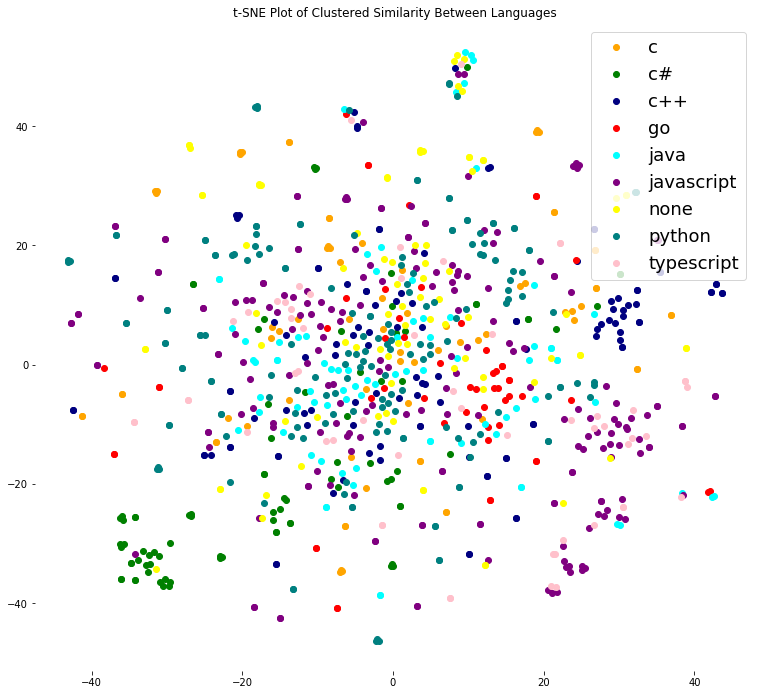

In [108]:
# make a mapping from category to your favourite colors and labels
category_to_color = {0: 'orange', 1: 'green', 2:'navy', 3: 'red', 4: 'cyan', 5: 'purple', 6: 'yellow', 7: 'teal', 8: 'pink'}
category_to_label = {0: 'c', 1:'c#', 2:'c++', 3:'go', 4: 'java', 5: 'javascript', 6: 'none', 7: 'python', 8: 'typescript'}

# plot each category with a distinct label
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
# setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1],c=df.lang_encoded.values, marker="x", cmap='Greens')

for category, color in category_to_color.items():
    mask = df.lang_encoded == category
    ax.plot(X_embedded[mask, 0], X_embedded[mask, 1], 'o', 
            color=color, label=category_to_label[category])
plt.title('t-SNE Plot of Clustered Similarity Between Languages')
ax.legend(fontsize=18, loc='best')

# Perform a train/test split in order to work with some other models...

# Split Train/Test

In [109]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,lang_encoded
0,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485,6
1,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397,6
2,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429,6
3,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377,6
4,none,hak.lnk\nProject Name: hak.lnk\nDescription: R...,18,64,hak lnk project name hak lnk description resou...,59,0.921875,hak lnk project name hak lnk description resou...,59,hak lnk project name hak lnk description resou...,48,0.813559,0.750000,6


In [110]:
df_split_2 = df[['clean','language']]

In [111]:
X = df_split_2.clean
y = df_split_2.language
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

## Naive Bayes Model

In [112]:
# Define what the languages are... Since we are only using the top occuring languages, this list will be smaller than the first language list.

my_tags = list(df_split_2.language.unique())
my_tags

['none', 'c++', 'python', 'javascript', 'go', 'java', 'typescript', 'c#', 'c']

In [113]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

%time
from sklearn.metrics import classification_report
y_pred = nb.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.82 µs
accuracy 0.32974910394265233
              precision    recall  f1-score   support

        none       1.00      0.05      0.09        22
         c++       1.00      0.43      0.60        21
      python       1.00      0.21      0.34        24
  javascript       0.00      0.00      0.00        22
          go       0.00      0.00      0.00        19
        java       0.23      1.00      0.38        57
  typescript       1.00      0.03      0.07        29
          c#       0.95      0.30      0.45        64
           c       0.00      0.00      0.00        21

   micro avg       0.33      0.33      0.33       279
   macro avg       0.58      0.22      0.21       279
weighted avg       0.61      0.33      0.27       279



/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Naive Bayes performs poorly at 32.9% accuracy. We want to optimize for accuracy so let's build more models.

# Linear Support Vector Machine

In [114]:
from sklearn.linear_model import SGDClassifier

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

%time

y_pred = sgd.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs
accuracy 0.6594982078853047
              precision    recall  f1-score   support

        none       0.91      0.45      0.61        22
         c++       0.85      0.81      0.83        21
      python       0.45      0.75      0.56        24
  javascript       0.83      0.68      0.75        22
          go       0.65      0.58      0.61        19
        java       0.61      0.81      0.69        57
  typescript       0.73      0.38      0.50        29
          c#       0.66      0.75      0.70        64
           c       0.89      0.38      0.53        21

   micro avg       0.66      0.66      0.66       279
   macro avg       0.73      0.62      0.64       279
weighted avg       0.70      0.66      0.65       279



## Linear SVM performs much better at 65% accuracy.

# Logistic Regression Model 2

In [115]:
from sklearn.linear_model import LogisticRegression

logreg = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
logreg.fit(X_train, y_train)

%time

y_pred = logreg.predict(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=my_tags))

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs
accuracy 0.6559139784946236
              precision    recall  f1-score   support

        none       0.79      0.50      0.61        22
         c++       0.85      0.81      0.83        21
      python       0.43      0.67      0.52        24
  javascript       0.83      0.68      0.75        22
          go       0.71      0.53      0.61        19
        java       0.60      0.81      0.69        57
  typescript       0.70      0.48      0.57        29
          c#       0.65      0.72      0.68        64
           c       1.00      0.38      0.55        21

   micro avg       0.66      0.66      0.66       279
   macro avg       0.73      0.62      0.65       279
weighted avg       0.70      0.66      0.65       279



## This Logistic Regression model performs at 65.67%, slightly worse than the first one.

In [116]:
import gensim

# Word2vec and Logistic Regression


In [117]:
print(gensim.__version__)

3.7.3


### Use gensim to load a word2vec model pretrained on google news and perform some simple actions with the word vectors.

In [118]:
from gensim.models import Word2Vec
path = '~/Documents/Coding/Codeup/CourseWork/ds-methodologies-exercises/nlp/'
file = "GoogleNews-vectors-negative300.bin.gz"
wv = gensim.models.KeyedVectors.load_word2vec_format(path+file, binary=True)
wv.init_sims(replace=True)

In [119]:
# def tsne_plot(model):
#     "Creates and TSNE model and plots it"
#     labels = []
#     tokens = []

#     for word in model.wv.vocab:
#         tokens.append(model[word])
#         labels.append(word)
    
#     tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
#     new_values = tsne_model.fit_transform(tokens)

#     x = []
#     y = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
        
#     plt.figure(figsize=(16, 16)) 
#     for i in range(len(x)):
#         plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')

#         plt.show()

In [120]:
# This operation takes too long to run on my system. So not running it...
# tsne_plot(wv)

###  Normalize the word2vec vectors first, so they all have equal length. 

### Load up a Google News model. 

In [121]:
from itertools import islice
list(islice(wv.vocab, 13030, 13050))

['Memorial_Hospital',
 'Seniors',
 'memorandum',
 'elephant',
 'Trump',
 'Census',
 'pilgrims',
 'De',
 'Dogs',
 '###-####_ext',
 'chaotic',
 'forgive',
 'scholar',
 'Lottery',
 'decreasing',
 'Supervisor',
 'fundamentally',
 'Fitness',
 'abundance',
 'Hold']

### Define some functions to perform Bag of Words analysis on the word vectors. Simple stuff like word averaging, summation, and weighted addition.

In [127]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.syn0norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
#         logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def  word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, post) for post in text_list ])

In [128]:
import nltk
from nltk.tokenize.toktok import ToktokTokenizer

### Tokenize the text, Train/Test split...

In [129]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,lang_encoded
0,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485,6
1,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397,6
2,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429,6
3,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377,6
4,none,hak.lnk\nProject Name: hak.lnk\nDescription: R...,18,64,hak lnk project name hak lnk description resou...,59,0.921875,hak lnk project name hak lnk description resou...,59,hak lnk project name hak lnk description resou...,48,0.813559,0.750000,6


In [130]:
def w2v_tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens
    
train, test = train_test_split(df, test_size=0.3, random_state = 42)

test_tokenized = test.apply(lambda r: w2v_tokenize_text(r['clean']), axis=1).values
train_tokenized = train.apply(lambda r: w2v_tokenize_text(r['clean']), axis=1).values

X_train_word_average = word_averaging_list(wv,train_tokenized)
X_test_word_average = word_averaging_list(wv,test_tokenized)

In [131]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg = logreg.fit(X_train_word_average, train['language'])
y_pred = logreg.predict(X_test_word_average)
print('accuracy %s' % accuracy_score(y_pred, test.language))
print(classification_report(test.language, y_pred,target_names=my_tags))

accuracy 0.5304659498207885
              precision    recall  f1-score   support

        none       0.46      0.59      0.52        22
         c++       0.70      0.76      0.73        21
      python       0.37      0.58      0.45        24
  javascript       0.81      0.59      0.68        22
          go       0.32      0.37      0.34        19
        java       0.51      0.61      0.56        57
  typescript       0.63      0.41      0.50        29
          c#       0.58      0.45      0.51        64
           c       0.60      0.43      0.50        21

   micro avg       0.53      0.53      0.53       279
   macro avg       0.55      0.53      0.53       279
weighted avg       0.56      0.53      0.53       279



## The Word2vec and Logistic Regression model performs at 53% accuracy.

# BOW with Keras


In [132]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from keras.layers import Dense, Activation, Dropout
from keras.preprocessing import text, sequence
from keras import utils
from keras.models import Sequential

import keras
from keras import models
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.datasets import mnist
from keras.utils.vis_utils import model_to_dot

Using TensorFlow backend.


In [133]:
print(keras.__version__)

2.2.4


In [134]:
df.head()

,language,original,stars,original_cnt,article,article_cnt,article_per_kept,lemmatized,lemm_cnt,clean,word_cnt_after_stop,per_stopwords_kept,per_overall_kept,lang_encoded
0,none,"NetBSD\nNetBSD is a free, fast, secure, and hi...",157,169,netbsd netbsd is a free fast secure and highly...,188,1.112426,netbsd netbsd is a free fast secure and highly...,188,netbsd netbsd free fast secure highly portable...,139,0.739362,0.822485,6
1,none,About the easyEPG project\nThis is the free pl...,20,63,about the easyepg project this is the free pla...,66,1.047619,about the easyepg project this is the free pla...,66,easyepg project free platform download epg dat...,52,0.787879,0.825397,6
2,none,andrewrothstein.vagrant\n\nInstalls vagrant\nR...,2,28,andrewrothstein vagrant installs vagrant requi...,37,1.321429,andrewrothstein vagrant installs vagrant requi...,37,andrewrothstein vagrant installs vagrant requi...,37,1.000000,1.321429,6
3,none,Free ShadowsocksR免费 ShadowsocksR 服务\nLatest up...,27,616,free shadowsocksr shadowsocksr latest update a...,616,1.000000,free shadowsocksr shadowsocksr latest update a...,616,free shadowsocksr shadowsocksr latest update s...,615,0.998377,0.998377,6
4,none,hak.lnk\nProject Name: hak.lnk\nDescription: R...,18,64,hak lnk project name hak lnk description resou...,59,0.921875,hak lnk project name hak lnk description resou...,59,hak lnk project name hak lnk description resou...,48,0.813559,0.750000,6


In [135]:
df.shape

(927, 14)

### Split Train/Test... 

### Tokenize and then turn texts to matrix.

In [136]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=random_state)
train = pd.DataFrame(dict(label=y_train, clean=X_train))
test = pd.DataFrame(dict(label=y_test, clean=X_test))
train

,label,clean
730,typescript,notable download markdown based note taking ap...
31,none,ipasn ip asn list note updated least every 24 ...
505,javascript,umi mobx antd mobile starter get started umi j...
382,javascript,fre fast 1kb react like library hooks api feat...
42,none,easy hosts github hosts google ip google issue...
883,c,pineconepi nano click enter website support su...
76,none,easy hosts github hosts google ip google issue...
26,none,rustlang cn pr markdown mit rustlang cn docs m...
893,c,systemd system service manager details general...
801,c#,hastlayer sdk readme overview hastlayer hardwa...


In [139]:
# train_size = int(len(df) * .7)
# train_text = df['clean'][:train_size]
# train_label = df['language'][:train_size]

# test_text = df['clean'][train_size:]
# test_label = df['language'][train_size:]

max_words = 1000
tokenize = text.Tokenizer(num_words=max_words, char_level=False)
tokenize.fit_on_texts(train.clean) # only fit on train

x_train = tokenize.texts_to_matrix(train.clean)
x_test = tokenize.texts_to_matrix(test.clean)


In [ ]:
# # print(train_size)
# # print(train_text)
# # print(train_label)
# # print(test_text)
# print(test_label)

# # print(type(tokenize))

# # print(x_train)
# # print(len(x_train))
# # print(x_test)
# # print(len(x_test))

In [140]:
encoder = LabelEncoder()
encoder.fit(train.label)
y_train = encoder.transform(train.label)
y_test = encoder.transform(test.label)

In [141]:
print(y_train)
print(len(y_train))
# print(y_test)
# print(len(y_test))

[8 6 5 5 6 0 6 6 0 1 3 4 0 4 2 2 2 6 5 3 0 5 6 5 1 3 1 0 0 4 7 5 6 0 5 5 1
 5 7 4 8 5 7 7 1 7 3 3 4 5 5 5 2 4 0 7 5 3 8 5 5 0 7 7 1 0 2 2 0 1 4 7 7 5
 4 1 0 0 5 6 4 5 2 7 3 5 1 5 5 1 6 3 3 5 4 6 5 3 5 0 7 4 5 7 4 5 4 2 0 0 7
 6 3 1 5 5 7 4 1 5 5 0 3 2 5 3 7 0 2 5 4 3 2 3 0 6 7 2 8 4 7 2 1 5 7 2 8 0
 5 8 7 7 6 2 8 0 1 2 5 6 5 5 7 5 7 7 7 2 2 4 1 5 2 8 7 4 5 1 5 2 7 2 8 6 5
 6 1 3 2 3 2 7 0 8 5 5 2 7 4 6 8 2 1 4 2 7 1 2 8 6 4 7 4 5 4 6 0 2 7 7 5 7
 6 7 5 5 0 2 7 4 8 7 5 5 6 5 5 4 5 7 8 2 7 5 7 7 5 7 0 2 7 6 4 5 5 5 2 0 5
 5 0 3 8 7 2 8 5 7 1 6 7 8 6 2 2 4 0 4 1 2 2 8 2 1 5 4 1 5 1 5 6 5 2 6 2 6
 7 7 1 7 7 6 5 7 1 7 5 6 4 0 0 1 2 1 5 7 2 4 5 1 5 6 7 4 8 4 7 4 2 7 2 7 2
 0 7 7 7 4 5 6 2 1 1 4 8 5 7 5 7 8 1 2 5 4 5 5 6 5 0 7 6 8 7 7 5 8 7 7 1 4
 0 5 7 2 5 1 7 7 6 6 7 7 7 3 1 6 5 0 7 6 3 6 7 4 1 1 5 5 6 6 8 5 1 7 1 5 3
 5 0 2 6 0 0 8 6 2 8 0 3 1 5 2 2 8 5 5 0 2 3 5 7 5 7 5 4 2 4 1 2 2 5 7 2 2
 3 7 5 7 6 6 8 6 5 8 8 0 1 5 6 7 1 5 5 4 4 1 2 2 4 5 5 4 1 3 5 2 7 7 2 6 5
 2 1 1 7 7 1 2 3 5 2 2 3 

In [142]:
y_test

array([3, 5, 1, 5, 0, 8, 0, 5, 5, 5, 1, 3, 5, 7, 0, 1, 0, 5, 2, 5, 8, 7,
       6, 6, 5, 1, 1, 5, 6, 2, 5, 7, 8, 4, 3, 7, 6, 7, 6, 5, 4, 4, 2, 2,
       7, 2, 1, 6, 7, 5, 8, 5, 7, 0, 6, 5, 4, 7, 2, 5, 2, 5, 0, 4, 8, 7,
       7, 5, 4, 7, 7, 5, 1, 7, 1, 5, 2, 3, 5, 0, 7, 6, 2, 0, 7, 0, 7, 3,
       7, 2, 1, 5, 7, 4, 2, 3, 8, 6, 6, 5, 6, 5, 7, 2, 0, 2, 0, 6, 5, 1,
       3, 7, 5, 8, 7, 7, 7, 3, 3, 6, 1, 2, 7, 7, 2, 2, 2, 7, 5, 5, 7, 6,
       7, 7, 5, 2, 8, 5, 5, 7, 2, 8, 5, 4, 0, 5, 8, 2, 4, 4, 1, 7, 1, 5,
       8, 2, 5, 8, 0, 4, 4, 6, 5, 4, 4, 2, 7, 1, 4, 5, 8, 8, 7, 1, 7, 7,
       6, 1, 6, 3, 2, 3, 4, 7, 0, 2, 6, 4, 4, 2, 3, 7, 5, 5, 5, 2, 5, 5,
       4, 7, 5, 1, 3, 2, 2, 0, 5, 7, 6, 7, 1, 5, 4, 7, 3, 5, 3, 5, 7, 5,
       6, 4, 0, 7, 7, 1, 7, 4, 6, 7, 1, 1, 0, 7, 5, 2, 7, 5, 0, 0, 1, 6,
       2, 5, 1, 8, 2, 5, 1, 2, 4, 6, 7, 0, 0, 7, 0, 5, 5, 3, 4, 5, 7, 6,
       5, 5, 8, 5, 5, 2, 4, 2, 8, 1, 1, 6, 5, 5, 2])

In [143]:
np.max(y_train)

8

In [144]:
y_train.shape

(648,)

In [145]:
num_classes = int(np.max(y_train)) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)


In [146]:
y_train.shape

(648, 9)

In [147]:


batch_size = 32
epochs = 4

# Build the model
model = Sequential()
# print(type(model))
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))


model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
              
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 583 samples, validate on 65 samples
Epoch 1/4
583/583 [==============================] - 1s 1ms/step - loss: 2.0810 - acc: 0.2727 - val_loss: 1.6543 - val_acc: 0.5231
Epoch 2/4
583/583 [==============================] - 0s 415us/step - loss: 1.3934 - acc: 0.6278 - val_loss: 1.3906 - val_acc: 0.5846
Epoch 3/4
583/583 [==============================] - 0s 398us/step - loss: 0.9793 - acc: 0.7959 - val_loss: 1.2279 - val_acc: 0.6615
Epoch 4/4
583/583 [==============================] - 0s 406us/step - loss: 0.7062 - acc: 0.8782 - val_loss: 1.1064 - val_acc: 0.6462


## Achieved accuracy of 87.83% in 4 epochs

In [148]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('Test score:', score[0])
print('Test accuracy:', score[1])

279/279 [==============================] - 0s 84us/step
Test score: 1.2900976173339351
Test accuracy: 0.6200716848014504


## Achieved accuracy of 62% on the Test dataset.